In [15]:
# external packages
import numpy as np
from scipy import interpolate
from scipy import optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# internal imports
from AneurysmGeneration.utils.batch import *
from AneurysmGeneration.utils.interpolation import *
from AneurysmGeneration.utils.normalization import *
from AneurysmGeneration.utils.parser import *
from AneurysmGeneration.utils.slice import *
from AneurysmGeneration.utils.batch import *
from AneurysmGeneration.utils.branch_ops import *

%matplotlib notebook

Read in the centerlines

In [3]:
model_dir = "/Users/alex/Documents/lab/KD-project/AneurysmGeneration/models/SKD0050/"
resampled = read_from_file('centerlines')

reading structures from pickle
------------------------------


In [11]:
print (resampled[0].shape)

(2370, 3)


In [52]:
class ComputeCurvature:
    """
        Adapted from https://math.stackexchange.com/questions/2507540/numerical-way-to-solve-for-the-curvature-of-a-curve
    """
    def __init__(self):
        """ Initialize some variables """
        self.xc = 0  # X-coordinate of circle center
        self.yc = 0  # Y-coordinate of circle center
        self.zc = 0  # Z-coordinate of circle center
        
        self.r = 0   # Radius of the circle
        self.xx = np.array([])  # Data points
        self.yy = np.array([])  # Data points
        self.zz = np.array([])

    def calc_r(self, xc, yc, zc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((self.xx-xc)**2 + (self.yy-yc)**2 + (self.zz-zc)**2)

    def f(self, c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        ri = self.calc_r(*c)
        return ri - ri.mean()

    def df(self, c):
        """ Jacobian of f_2b
        The axis corresponding to derivatives must be coherent with the col_deriv option of leastsq"""
        xc, yc, zc = c
        df_dc = np.empty((len(c), self.xx.size))
        
        ri = self.calc_r(xc, yc, zc)
        df_dc[0] = (xc - self.xx)/ri                   # dR/dxc
        df_dc[1] = (yc - self.yy)/ri                   # dR/dyc
        df_dc[2] = (zc - self.zz)/ri                   # dR/dzc
        df_dc = df_dc - df_dc.mean(axis=1)[:, np.newaxis]
        return df_dc

    def fit(self, xx, yy, zz):
        self.xx = xx
        self.yy = yy
        self.zz = zz
        
        center_estimate = np.r_[np.mean(xx), np.mean(yy), np.mean(zz)]
        center = optimize.leastsq(self.f, center_estimate, Dfun=self.df, col_deriv=True)[0]

        self.xc, self.yc, self.zc = center
        ri = self.calc_r(*center)
        self.r = ri.mean()

        return 1 / self.r  # Return the curvature



(3, 2370)
(2370,)
(3, 2370)
(2370,)
(3, 2370)
(2370,)
(3, 2370)
(2370,)
(3, 2370)
(2370,)
(3, 2370)
(2370,)
(3, 2370)
(2370,)


<IPython.core.display.Javascript object>


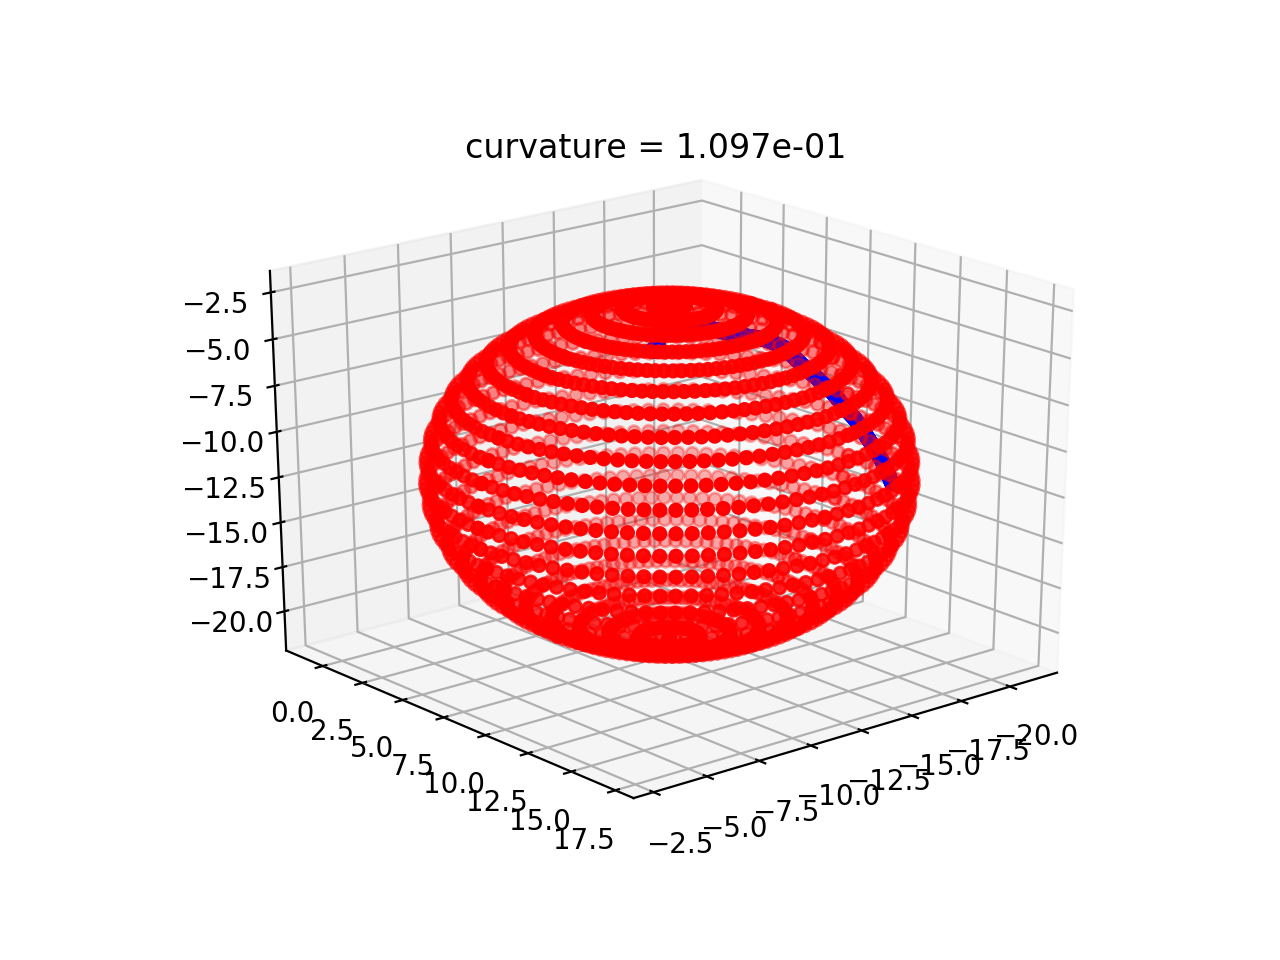

Text(0.5,0.92,'curvature = 1.097e-01')

In [47]:
# Apply code for an example
centerline = resampled[0]
x = centerline[:,0]
y = centerline[:,1]
z = centerline[:,2]

comp_curv = ComputeCurvature()
curvature = comp_curv.fit(x, y, z)

# pretty sure the conversion from 2d -> 3d for this code means that we're # we're now fitting a spherical shell parameterized in radius, center

# spaced spherical coordinates
theta_range = np.linspace(-np.pi, np.pi, 50)
phi_range = np.linspace(-np.pi, np.pi, 50)
theta_mesh, phi_mesh = np.meshgrid(theta_range, phi_range)

# transformation to cartesian
x_fit = comp_curv.xc + comp_curv.r*np.cos(theta_mesh)*np.sin(phi_mesh)
y_fit = comp_curv.yc + comp_curv.r*np.sin(theta_mesh)*np.sin(phi_mesh)
z_fit = comp_curv.zc + comp_curv.r*np.cos(phi_mesh)



# do some 3d plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='b')
ax.scatter(x_fit, y_fit, z_fit, c='r')
plt.title('curvature = {:.3e}'.format(curvature))

# plt.plot(x_fit, y_fit, 'k--', label='fit', lw=2)
# plt.plot(x, y, 'ro', label='data', ms=8, mec='b', mew=1)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('curvature = {:.3e}'.format(curvature))
# plt.show()


Next, we need to trim the centerline to fit just the aneurysmal region

reading structures from pickle
------------------------------
normalizing the centerline
--------------------------
splitting centerline normalization: 100%|██████████| 2863/2863 [00:00<00:00, 229867.77it/s]
0.683807061212726
(2864,)
(1470, 3)
(1470,) (1470,) (1470,)
[-8.77476557 -8.77165537 -8.76854674 ... -5.59483733 -5.59493317
 -5.5950318 ]


<IPython.core.display.Javascript object>


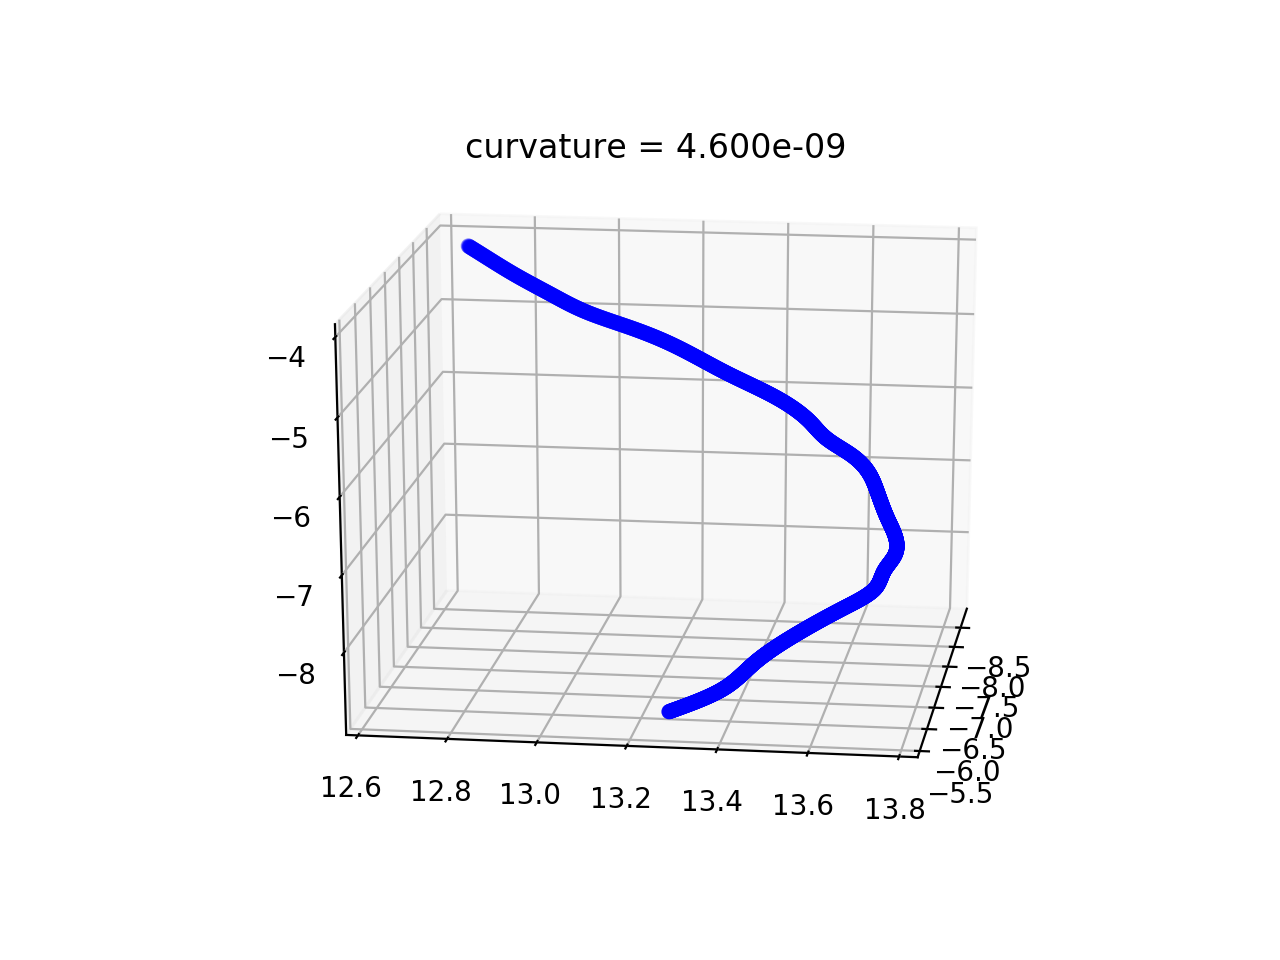

Text(0.5,0.92,'curvature = 4.600e-09')

In [68]:
# centerline = resampled[2]
centerline = read_from_file('RCA_cl')

start = .17 
length = 6.0229

NoP_center, normalized_center, centerline_length = normalized_centerline_pth(centerline)

end = start + length/centerline_length
print end
print normalized_center.shape

selected = np.where(np.logical_and(np.greater_equal(normalized_center, start), np.less_equal(normalized_center, end)))
print centerline[selected].shape

centerline = centerline[selected]
x = centerline[:,0]
y = centerline[:,1]
z = centerline[:,2]

print x.shape, y.shape, z.shape
print x
# -------------------------------------------------------------------------------------------------------------------
comp_curv = ComputeCurvature()
curvature = comp_curv.fit(x, y, z)

# pretty sure the conversion from 2d -> 3d for this code means that we're # we're now fitting a spherical shell parameterized in radius, center


# spaced spherical coordinates
theta_range = np.linspace(-np.pi, np.pi, 10)
phi_range = np.linspace(-np.pi, np.pi, 10)
theta_mesh, phi_mesh = np.meshgrid(theta_range, phi_range)

# transformation to cartesian
x_fit = comp_curv.xc + comp_curv.r*np.cos(theta_mesh)*np.sin(phi_mesh)
y_fit = comp_curv.yc + comp_curv.r*np.sin(theta_mesh)*np.sin(phi_mesh)
z_fit = comp_curv.zc + comp_curv.r*np.cos(phi_mesh)



# do some 3d plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='b')
# ax.scatter(x_fit, y_fit, z_fit, c='r')
plt.title('curvature = {:.3e}'.format(curvature))


Wrap this computation in a function so we can repeatedly call

In [49]:
def compute_curvature(centerline, start, length):
    
    NoP_center, normalized_center, centerline_length = normalized_centerline_pth(centerline)
    end = start + length/centerline_length
    
    selected = np.where(np.logical_and(
                        np.greater_equal(normalized_center, start), 
                        np.less_equal(normalized_center, end)
                        ))
    
    print centerline[selected].shape

    centerline = centerline[selected]
    x = centerline[:,0]
    y = centerline[:,1]
    z = centerline[:,2]
    
    comp_curv = ComputeCurvature()
    curvature = comp_curv.fit(x, y, z)
    
    print 'computed curvature is', curvature
    return curvature

    
    

All start, length information with dictionary mapping for convenience

In [50]:
right_start_lengths = {
    'ASI2': {
        'prox': [[.17, 1.3068], [.17, 1.5404], [.17, 1.7740], [.17, 2.0076], [.17, 2.22412]],
        'med': [[.55, 1.3068], [.55, 1.5404], [.55, 1.7740], [.55, 2.0076], [.55, 2.22412]], 
        'dist': [[.77, 1.3068], [.77, 1.5404], [.77, 1.7740], [.77, 2.0076], [.77, 2.22412]],
        },
    'ASI4': {
        'prox': [[.17, 2.6137], [.17, 3.0809], [.17, 3.5481], [.17, 4.0152], [.17, 4.4824]],
        },
    'ASI6': {
        'prox': [[.17, 3.9205], [.17, 4.6213], [.17, 5.3221], [.17, 6.0229], [.17, 6.7236]],
        },

}

In [65]:
curvatures = {'ASI2':None, 'ASI4': None, 'ASI6':None}
#centerline = resampled[2]
centerline = read_from_file('RCA_cl')

for shape, pos_dict in right_start_lengths.iteritems(): 
    pos_curves = {}
    for pos, start_lengths in pos_dict.iteritems():
        curv_vals = []
        for start, length in start_lengths: 
            print shape, pos
            curv_vals.append(compute_curvature(centerline, start, length))
            
        pos_curves[pos] = curv_vals
    
    curvatures[shape] = pos_curves

reading structures from pickle
------------------------------
ASI6 prox
normalizing the centerline
--------------------------
splitting centerline normalization: 100%|██████████| 2863/2863 [00:00<00:00, 136177.77it/s]
(957, 3)
computed curvature is 0.0387793436963596
ASI6 prox
normalizing the centerline
--------------------------
splitting centerline normalization: 100%|██████████| 2863/2863 [00:00<00:00, 144136.41it/s]
(1128, 3)
computed curvature is 0.0019238591324194114
ASI6 prox
normalizing the centerline
--------------------------
splitting centerline normalization: 100%|██████████| 2863/2863 [00:00<00:00, 173169.88it/s]
(1299, 3)
computed curvature is 0.04281495941556752
ASI6 prox
normalizing the centerline
--------------------------
splitting centerline normalization: 100%|██████████| 2863/2863 [00:00<00:00, 147341.01it/s]
(1470, 3)
computed curvature is 4.599627494481772e-09
ASI6 prox
normalizing the centerline
--------------------------
splitting centerline normalization: 100%

In [66]:
curvatures

{'ASI2': {'dist': [0.2649296762333266,
   0.3252152900060654,
   0.32468676972583554,
   0.3237936695625545,
   0.3237765112915903],
  'med': [1.2320030621566273e-07,
   0.2425784661065677,
   0.24185032549742874,
   0.24328725876209104,
   0.25061873199782697],
  'prox': [0.025487515478460097,
   0.04969170122638968,
   0.04359390677927474,
   0.046220171205615015,
   0.030827091103516287]},
 'ASI4': {'prox': [0.033445356061712596,
   0.04435025757613351,
   0.04225784267292807,
   0.0370468275330912,
   0.01608374577623039]},
 'ASI6': {'prox': [0.0387793436963596,
   0.0019238591324194114,
   0.04281495941556752,
   4.599627494481772e-09,
   0.107021422905661]}}